## Library imports

In [1]:
import sys
sys.path.append('../input/dl-optimization-repos/')

# import necessary libraries
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
from typing import Any, List, Union
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


# DL library imports
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import OneCycleLR
from torchvision.models.resnet import conv1x1, conv3x3


# torch Dataset required imports
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

# custom imports
from scripts.modelMetrics import modelMetrics
from scripts.modelUtils import setSeed, trainValidateModel, evaluteOnTestData, meanClassificationAccuracyMetric

## Config params

In [3]:
class CFG:
    SEED        = 1
    NUM_CLASSES = 10
    N_EPOCHS    = 10
    NUM_WORKERS = 1
    TEST_BATCH_SIZE  = 16
    TRAIN_BATCH_SIZE = 16
    VAL_SET_SIZE = 0.2    # percentage of split of train set for validation

    # loss fn parameters
    LOSS_FN     = 'CrossEntropyLoss'
            
    # optimizer variables
    MAX_LR    = 1e-3
    MIN_LR    = 1e-6
    SCHEDULER = 'OneCycleLr'
    T_0       = 2
    T_MULT    = 2
               
    TRAIN_MODEL = True    
    
    ROOT_PATH = ''
    MODEL_SAVE_PATH = '.'
    PRETRAINED_PATH = ''
    
    # number of test samples to visualize prediction
    NUM_TEST_SAMPLES = 2

setSeed(CFG.SEED)

## Dataset

In [3]:
dataSetLabels = ['TShirt', 'Trouser', 'Pullover', 'Dress', 'Coat', \
                 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'AnkleBoot']

# necessary image transform i.e. convert to Tensor, normalize
trainTransform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)) ])
testTransform  = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)) ])

# Download the Train and Test set
trainSet = datasets.FashionMNIST('.', train=True, download=True, transform=trainTransform)
testSet = datasets.FashionMNIST('.', train=False, download=True, transform=testTransform)

In [4]:
# Split the training set indices into training and validation set indices 
lenTrainSet = len(trainSet)
indexList = list(range(lenTrainSet))
np.random.shuffle(indexList)
splitIndex = int(lenTrainSet * CFG.VAL_SET_SIZE)
trainIndices, validIndices = indexList[splitIndex:], indexList[:splitIndex]

# Create Samplers for training and validation set using the indices
trainSampler = SubsetRandomSampler(trainIndices)
validSampler = SubsetRandomSampler(validIndices)

# Create loaders for train, validation and testing set using samplers
trainLoader = DataLoader(trainSet, batch_size=CFG.TRAIN_BATCH_SIZE, sampler=trainSampler, num_workers=CFG.NUM_WORKERS)
validLoader = DataLoader(trainSet, batch_size=CFG.TEST_BATCH_SIZE,  sampler=validSampler, num_workers=CFG.NUM_WORKERS)
testLoader  = DataLoader(testSet,  batch_size=CFG.TEST_BATCH_SIZE,  shuffle=True,num_workers=CFG.NUM_WORKERS)

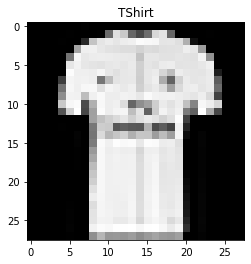

In [5]:
# view sample from dataset
img, label = next(iter(trainLoader))
plt.imshow(img[0].numpy().squeeze(), cmap = 'Greys_r')
plt.title(f'{dataSetLabels[label[0].item()]}')
plt.show()

## Model definition

In [6]:
class residualBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels : int, block_channels : int,
                stride : int =1, downsample : Any = None) -> None:        
        super(residualBlock, self).__init__()

        # first sub-block
        self.conv1 = conv3x3(in_planes=in_channels, out_planes=block_channels,
                            stride=stride)
        self.bn1 = nn.BatchNorm2d(block_channels)
        self.relu = nn.ReLU(inplace=True)

        # second sub-block
        self.conv2 = conv3x3(in_planes=block_channels, out_planes=block_channels)
        self.bn2 = nn.BatchNorm2d(block_channels)

        # store downsample 
        self.downsample = downsample


    def forward(self, x : torch.Tensor) -> torch.Tensor:
        # store input and project if size differs
        identity = x
        if(self.downsample is not None):
            identity = self.downsample(x)

        # 1st sub-block
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        # 2nd sub-block
        out = self.conv2(out)
        out = self.bn2(out)

        # residual connection
        out += identity
        out = self.relu(out)
        return out

In [7]:
class plainBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels : int, block_channels : int,
                stride : int =1, downsample : Any = None) -> None:        
        super(plainBlock, self).__init__()

        # first sub-block
        self.conv1 = conv3x3(in_planes=in_channels, out_planes=block_channels,
                            stride=stride)
        self.bn1 = nn.BatchNorm2d(block_channels)
        self.relu = nn.ReLU(inplace=True)

        # second sub-block
        self.conv2 = conv3x3(in_planes=block_channels, out_planes=block_channels)
        self.bn2 = nn.BatchNorm2d(block_channels)

    def forward(self, x : torch.Tensor) -> torch.Tensor:
        # 1st sub-block
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        # 2nd sub-block
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        return out

In [8]:
class demoNet(nn.Module):
    def __init__(self, block : Any, in_channels, layers : List[int],
                 num_classes : int = 1000) -> None:
        super().__init__()

        # temporary variable
        self.in_planes = 16
        
        # 1st conv-bn-relu-maxpool block
        self.conv1 = nn.Conv2d(in_channels, out_channels=self.in_planes, kernel_size=7, stride=2,
                                padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # create layers of residual net
        self.layer1 = self._make_layer(block, self.in_planes, layers[0])
        self.layer2 = self._make_layer(block, self.in_planes * 2, layers[1], stride=2)

        # classifier section of residual network
        self.avgPool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(32 * block.expansion, num_classes)
    
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    
    def _make_layer(self, block : Any, planes : int, \
                    num_blocks : int, stride :int = 1) -> nn.Module:
        downsample = None        
        if(stride !=1):
            downsample = nn.Sequential( 
                conv1x1(in_planes= self.in_planes, out_planes= planes * block.expansion, stride=stride),
                nn.BatchNorm2d(planes * block.expansion))
          
        layers = []        
        layers.append(block(self.in_planes, planes, downsample=downsample, stride=stride))
        self.in_planes = planes * block.expansion
        for i in range(1, num_blocks):
            layers.append(block(self.in_planes, planes))
        output = nn.Sequential(*layers)
        return output


    def forward(self, x : torch.Tensor) -> torch.Tensor:      
        # initial feature extractor block
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)

        # residual layers forward pass
        out = self.layer1(out)
        out = self.layer2(out)
        
        # avgPool followed by full-connected layer
        out = self.avgPool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

## Loss function, device

In [9]:
cpuDevice = torch.device("cpu")
gpuDevice = torch.device("cuda:0")
if torch.cuda.is_available() == True:
    device = gpuDevice
else:
    device = cpuDevice

criterion = nn.CrossEntropyLoss()

l2_1_conv1_ratio## Compare gradient between plain and residual nets

In [10]:
resnetModel = demoNet(block=residualBlock, in_channels=1, layers=[2,2], num_classes=10)
plainModel = demoNet(block=plainBlock, in_channels=1, layers=[2,2], num_classes=10)

In [11]:
# create list of common items in state_dict()
resnet_keys = resnetModel.state_dict().keys()
plainnet_keys = plainModel.state_dict().keys()
common_keys = list(set(resnet_keys).intersection(set(plainnet_keys)))

# update init values from resnet model to plain model
resnetModel_stateDict = resnetModel.state_dict()
plainModel_stateDict = plainModel.state_dict()
common_items = {k: v for k, v in resnetModel_stateDict.items() if k in plainModel_stateDict}
plainModel_stateDict.update(common_items)
plainModel.load_state_dict(plainModel_stateDict)
# Reference : https://discuss.pytorch.org/t/transfer-learning-of-weights-to-one-model-to-another/23962/6

<All keys matched successfully>

In [12]:
sampleInput, sampleLabel = next(iter(trainLoader))

In [13]:
resnetModel_preds = resnetModel(sampleInput)
resnetModel_loss = criterion(resnetModel_preds, sampleLabel)
resnetModel_loss.backward()

In [14]:
plainModel_preds = plainModel(sampleInput)
plainModel_loss = criterion(plainModel_preds, sampleLabel)
plainModel_loss.backward()

In [15]:
resnetModel_loss, plainModel_loss

(tensor(2.1166, grad_fn=<NllLossBackward>),
 tensor(2.2081, grad_fn=<NllLossBackward>))

In [16]:
# conv1 weight
conv1_ratio = torch.mean(torch.abs(resnetModel.conv1.weight.grad) /  torch.abs(plainModel.conv1.weight.grad))

# layer1[0] conv1 weight
l1_0_conv1_ratio = torch.mean(torch.abs(resnetModel.layer1[0].conv1.weight.grad) /  torch.abs(plainModel.layer1[0].conv1.weight.grad))

# layer1[0] conv2 weight
l1_0_conv2_ratio = torch.mean(torch.abs(resnetModel.layer1[0].conv2.weight.grad) /  torch.abs(plainModel.layer1[0].conv2.weight.grad))

# layer1[1] conv1 weight
l1_1_conv1_ratio = torch.mean(torch.abs(resnetModel.layer1[1].conv1.weight.grad) /  torch.abs(plainModel.layer1[1].conv1.weight.grad))

# layer1[1] conv2 weight
l1_1_conv2_ratio = torch.mean(torch.abs(resnetModel.layer1[1].conv2.weight.grad) /  torch.abs(plainModel.layer1[1].conv2.weight.grad))

# layer2[0] conv1 weight
l2_0_conv1_ratio = torch.mean(torch.abs(resnetModel.layer2[0].conv1.weight.grad) /  torch.abs(plainModel.layer2[0].conv1.weight.grad))

# layer2[0] conv2 weight
l2_0_conv2_ratio =  torch.mean(torch.abs(resnetModel.layer2[0].conv2.weight.grad) /  torch.abs(plainModel.layer2[0].conv2.weight.grad))

# layer2[1] conv1 weight
l2_1_conv1_ratio = torch.mean(torch.abs(resnetModel.layer2[1].conv1.weight.grad) /  torch.abs(plainModel.layer2[1].conv1.weight.grad))

# layer2[1] conv2 weight
l2_1_conv2_ratio = torch.mean(torch.abs(resnetModel.layer2[1].conv2.weight.grad) /  torch.abs(plainModel.layer2[1].conv2.weight.grad))


print(conv1_ratio)
print('-------------------')
print(l1_0_conv1_ratio)
print(l1_0_conv2_ratio)
print('-------------------')
print(l1_1_conv1_ratio)
print(l1_1_conv2_ratio)
print('-------------------')
print(l2_0_conv1_ratio)
print(l2_0_conv2_ratio)
print('-------------------')
print(l2_1_conv1_ratio)
print(l2_1_conv2_ratio)

tensor(9.6826)
-------------------
tensor(4.1171)
tensor(3.2113)
-------------------
tensor(5.7691)
tensor(4.6224)
-------------------
tensor(8.0079)
tensor(7.7563)
-------------------
tensor(5.4091)
tensor(6.2464)


In [43]:
import matplotlib
matplotlib.use('Agg')

def plot_conv_layers(data, title):
    data = data.detach().cpu().numpy()
    data = np.ma.masked_greater(data, 10.0)
    fig, ax = plt.subplots(figsize=(14,10))
    im = ax.imshow(data, cmap='plasma', interpolation='none')
    cbar = fig.colorbar(im, extend='max')
    cbar.cmap.set_over('green')
    ax.set_title(title)
    ax.axis('off')
    plt.savefig(f'{title}.png')

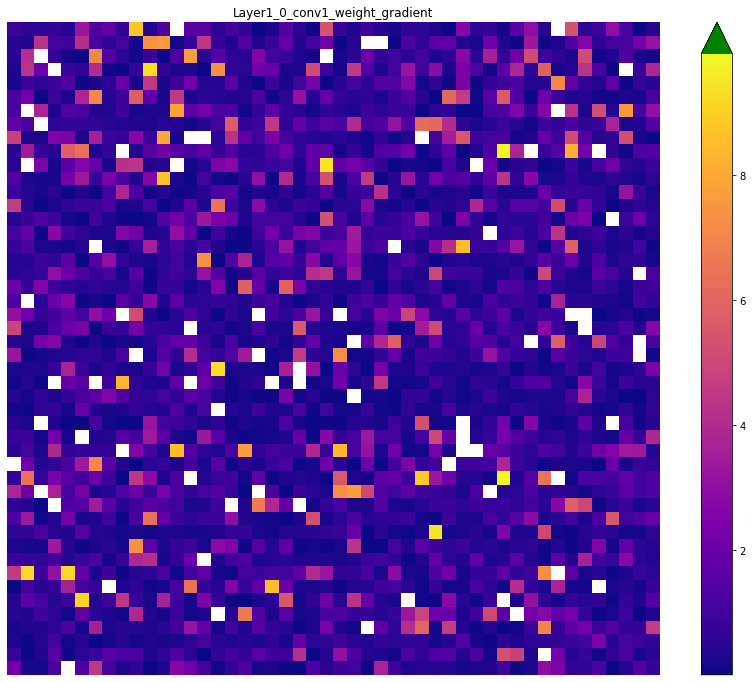

In [23]:
l1_0_conv1_ratio = torch.abs(resnetModel.layer1[0].conv1.weight.grad) /  torch.abs(plainModel.layer1[0].conv1.weight.grad)
num_channels, height, width  = l1_0_conv1_ratio.shape[1:]
l1_0_conv1_ratio = l1_0_conv1_ratio.view(CFG.TRAIN_BATCH_SIZE *  height, num_channels * width)
plot_conv_layers(l1_0_conv1_ratio, 'Layer1_0_conv1_weight_gradient')

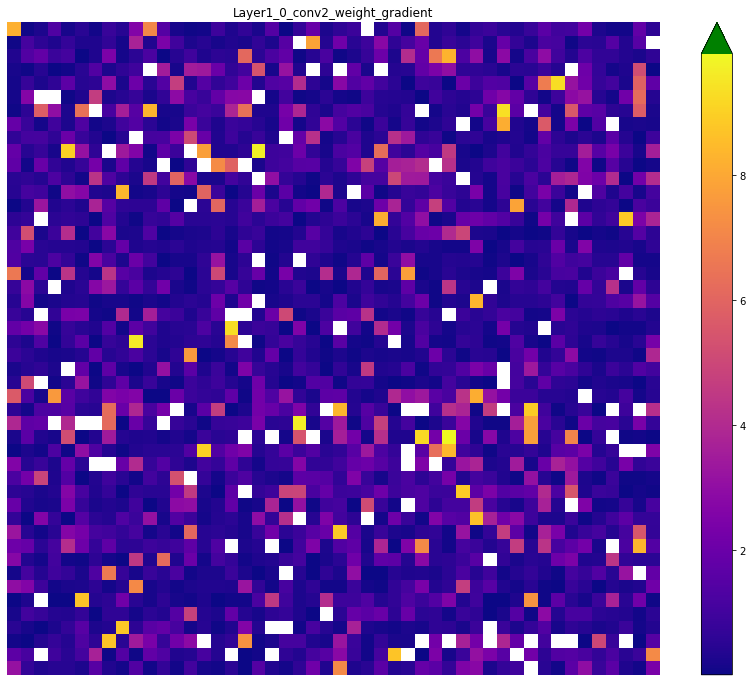

In [24]:
l1_0_conv2_ratio = torch.abs(resnetModel.layer1[0].conv2.weight.grad) /  torch.abs(plainModel.layer1[0].conv2.weight.grad)
num_channels, height, width  = l1_0_conv2_ratio.shape[1:]
l1_0_conv2_ratio = l1_0_conv2_ratio.view(CFG.TRAIN_BATCH_SIZE *  height, num_channels * width)
plot_conv_layers(l1_0_conv2_ratio, 'Layer1_0_conv2_weight_gradient')

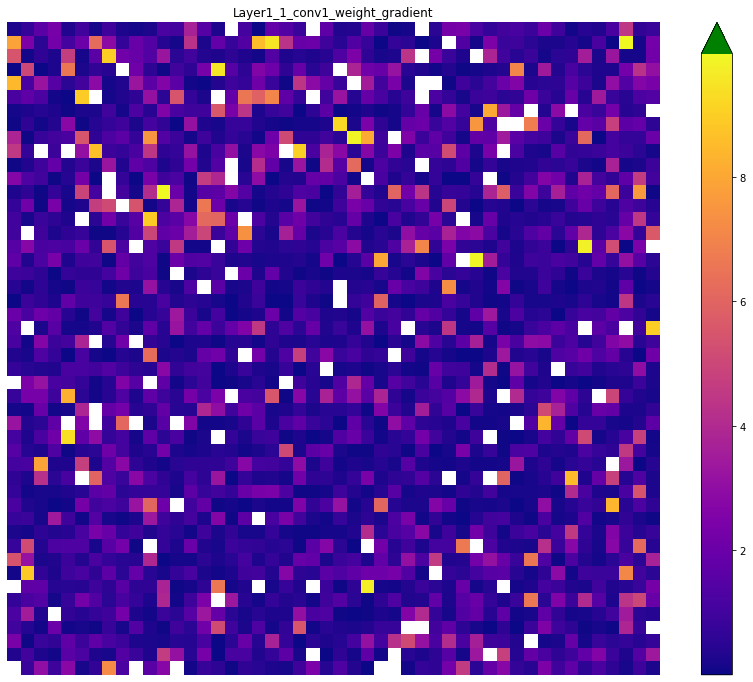

In [25]:
l1_1_conv1_ratio = torch.abs(resnetModel.layer1[1].conv1.weight.grad) /  torch.abs(plainModel.layer1[1].conv1.weight.grad)
num_channels, height, width  = l1_1_conv1_ratio.shape[1:]
l1_1_conv1_ratio = l1_1_conv1_ratio.view(CFG.TRAIN_BATCH_SIZE *  height, num_channels * width)
plot_conv_layers(l1_1_conv1_ratio, 'Layer1_1_conv1_weight_gradient')

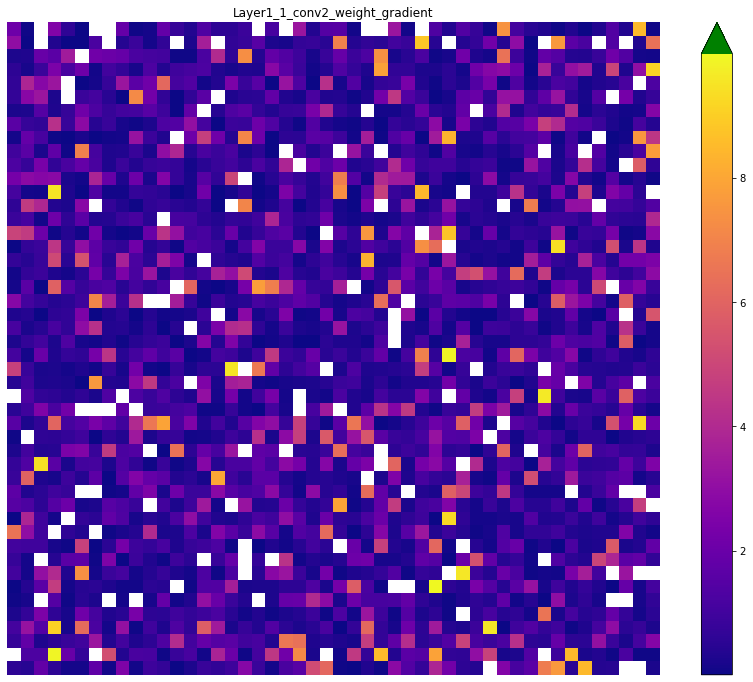

In [26]:
l1_1_conv2_ratio = torch.abs(resnetModel.layer1[1].conv2.weight.grad) /  torch.abs(plainModel.layer1[1].conv2.weight.grad)
num_channels, height, width  = l1_1_conv2_ratio.shape[1:]
l1_1_conv2_ratio = l1_1_conv2_ratio.view(CFG.TRAIN_BATCH_SIZE *  height, num_channels * width)
plot_conv_layers(l1_1_conv2_ratio, 'Layer1_1_conv2_weight_gradient')

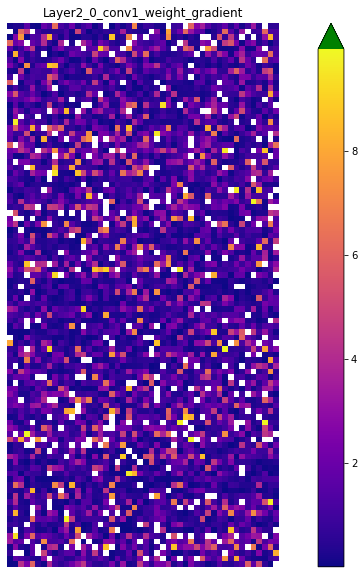

In [44]:
l2_0_conv1_ratio = torch.abs(resnetModel.layer2[0].conv1.weight.grad) /  torch.abs(plainModel.layer2[0].conv1.weight.grad)
out_ch, in_ch, height, width  = l2_0_conv1_ratio.shape
l2_0_conv1_ratio = l2_0_conv1_ratio.view(out_ch *  height, in_ch * width)
plot_conv_layers(l2_0_conv1_ratio, 'Layer2_0_conv1_weight_gradient')

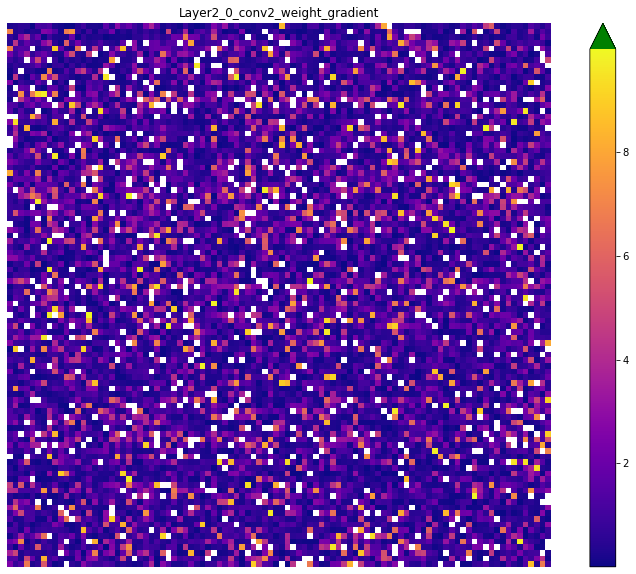

In [45]:
l2_0_conv2_ratio = torch.abs(resnetModel.layer2[0].conv2.weight.grad) /  torch.abs(plainModel.layer2[0].conv2.weight.grad)
out_ch, in_ch, height, width  = l2_0_conv2_ratio.shape
l2_0_conv2_ratio = l2_0_conv2_ratio.view(out_ch *  height, in_ch * width)
plot_conv_layers(l2_0_conv2_ratio, 'Layer2_0_conv2_weight_gradient')

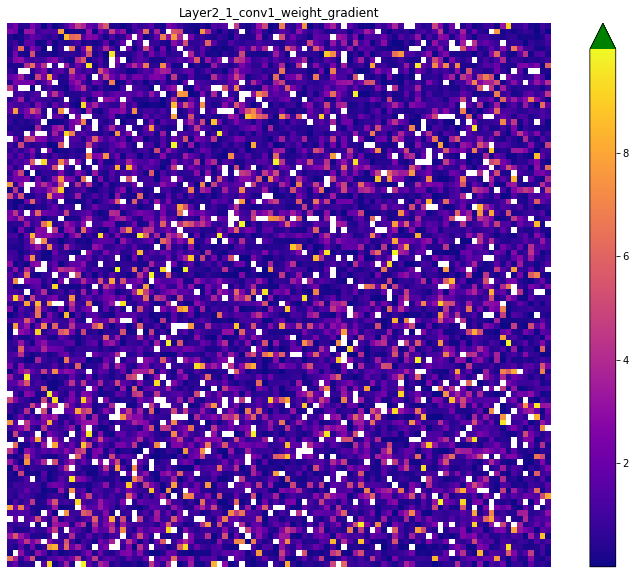

In [46]:
l2_1_conv1_ratio = torch.abs(resnetModel.layer2[1].conv1.weight.grad) /  torch.abs(plainModel.layer2[1].conv1.weight.grad)
out_ch, in_ch, height, width  = l2_1_conv1_ratio.shape
l2_1_conv1_ratio = l2_1_conv1_ratio.view(out_ch *  height, in_ch * width)
plot_conv_layers(l2_1_conv1_ratio, 'Layer2_1_conv1_weight_gradient')

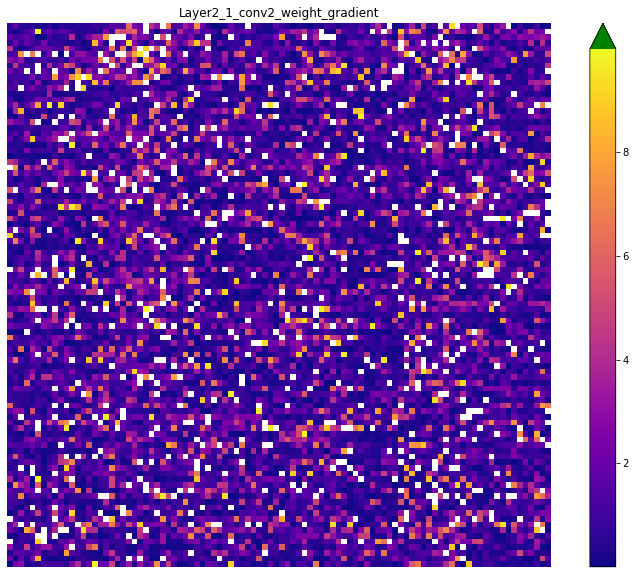

In [47]:
l2_1_conv2_ratio = torch.abs(resnetModel.layer2[1].conv2.weight.grad) /  torch.abs(plainModel.layer2[1].conv2.weight.grad)
out_ch, in_ch, height, width  = l2_1_conv2_ratio.shape
l2_1_conv2_ratio = l2_1_conv2_ratio.view(out_ch *  height, in_ch * width)
plot_conv_layers(l2_1_conv2_ratio, 'Layer2_1_conv2_weight_gradient')

## Train Residual Network

In [ ]:
if(CFG.TRAIN_MODEL == True):
    resnetModel = demoNet(block=residualBlock, in_channels=1, layers=[2,2], num_classes=10)
    optimizer = optim.Adam(resnetModel.parameters(), lr=CFG.MAX_LR)
    scheduler = OneCycleLR(optimizer, max_lr= CFG.MAX_LR, epochs = CFG.N_EPOCHS,
                           steps_per_epoch = len(trainLoader),                         
                           pct_start=0.3, div_factor=10, anneal_strategy='cos')    
    resnetModelResults = trainValidateModel(resnetModel, criterion, optimizer, trainLoader, validLoader, 
                                      meanClassificationAccuracyMetric, 'meanClassificationAccuracyMetric',
                                      device, CFG, modelName='demoResNet', lr_scheduler = scheduler, 
                                      saveModel=True, verbose=True, plotResults=True)

## Train Plain Network

In [ ]:
if(CFG.TRAIN_MODEL == True):
    plainModel = demoNet(block=plainBlock, in_channels=1, layers=[2,2], num_classes=10)
    optimizer = optim.Adam(plainModel.parameters(), lr=CFG.MAX_LR)
    scheduler = OneCycleLR(optimizer, max_lr= CFG.MAX_LR, epochs = CFG.N_EPOCHS,
                           steps_per_epoch = len(trainLoader),                         
                           pct_start=0.3, div_factor=10, anneal_strategy='cos')    
    plainModelResults = trainValidateModel(plainModel, criterion, optimizer, trainLoader, validLoader, 
                                      meanClassificationAccuracyMetric, 'meanClassificationAccuracyMetric',
                                      device, CFG, modelName='plainNet', lr_scheduler = scheduler, 
                                      saveModel=True, verbose=True, plotResults=True)

## Evaluate Plain and Residual nets on Test Data

In [ ]:
# load pretrained model and transfer to target Device
resnetModel = demoNet(block=residualBlock, in_channels=1, layers=[2,2], num_classes=10)
resnetModel.load_state_dict(torch.load('./demoResNet.pt', map_location=device))

# evaluate performance on Test set
resnetModelMetric = evaluteOnTestData(resnetModel, None, 
                   device, testLoader, meanClassificationAccuracyMetric, 
                    'meanClassificationAccuracyMetric', 'resnetModel', CFG, verbose=True)

In [ ]:
# load pretrained model and transfer to target Device
plainModel = demoNet(block=plainBlock, in_channels=1, layers=[2,2], num_classes=10)
plainModel.load_state_dict(torch.load('./plainNet.pt', map_location=device))

# evaluate performance on Test set
plainModelMetric = evaluteOnTestData(plainModel, None, 
                   device, testLoader, meanClassificationAccuracyMetric, 
                    'meanClassificationAccuracyMetric', 'resnetModel', CFG, verbose=True)